In [1]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics 8.3.40  Python-3.10.6 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4060, 8187MiB)
Setup complete  (12 CPUs, 15.9 GB RAM, 888.7/1863.0 GB disk)


In [29]:
def center_crop(frame, target_size=(480, 480)):
    h, w, _ = frame.shape
    crop_h, crop_w = target_size

    # Calculate cropping coordinates
    start_x = max(0, (w - crop_w) // 2)
    start_y = max(0, (h - crop_h) // 2)
    end_x = start_x + crop_w
    end_y = start_y + crop_h

    # Perform cropping
    cropped_frame = frame[start_y:end_y, start_x:end_x]
    return cropped_frame

# Object Detection

In [2]:
model = YOLO("runs/detect/train5/weights/best.pt")

## Webcam connected on pc

In [ ]:
import cv2

# Initialize the webcam (use 0 for default webcam, or 1, 2, etc., for external webcams)
cap = cv2.VideoCapture(0)

# model = YOLO("runs/detect/train5/weights/best.pt")

# Check if the webcam is opened correctly
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

# Loop to capture frames
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    # If frame is read correctly, ret will be True
    if not ret:
        print("Error: Cannot read frame.")
        break

    # results = model.predict(frame, imgsz=480)
    cropped_frame = center_crop(frame, target_size=(480, 480))
    results = model.predict(cropped_frame, imgsz=480)
    for result in results:
        for box in result.boxes:
            # Get bounding box coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Convert to integers
            conf = box.conf[0]  # Confidence score
            cls = int(box.cls[0])  # Class index
            label = model.names[cls]  # Class label from model

            # Draw the bounding box
            cv2.rectangle(cropped_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Add label and confidence score
            cv2.putText(cropped_frame, f"{label} {conf:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    # Display the resulting frame
    cv2.imshow('Webcam', cropped_frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()


## Phone camera

Steps:
1. Install **IP Webcam** (Thyoni Tech)
2. Scroll down and click on **Start Server** (make sure that PC and phone are connected on network)
3. Change the url

In [ ]:
# Import essential libraries 
import requests 
import cv2 
import numpy as np 

# Replace the below URL with your own. Make sure to add "/shot.jpg" at last. 
url = "http://192.168.188.30:8080/shot.jpg"

# While loop to continuously fetching data from the Url 
while True: 
	img_resp = requests.get(url) 
	img_arr = np.array(bytearray(img_resp.content), dtype=np.uint8) 
	frame = cv2.imdecode(img_arr, -1) 
	# cropped_frame = center_crop(frame, target_size=(480, 480))
	cropped_frame = frame
	results = model.predict(cropped_frame, imgsz=480)
	for result in results:
		for box in result.boxes:
			# Get bounding box coordinates
			x1, y1, x2, y2 = map(int, box.xyxy[0])  # Convert to integers
			conf = box.conf[0]  # Confidence score
			cls = int(box.cls[0])  # Class index
			label = model.names[cls]  # Class label from model

			# Draw the bounding box
			cv2.rectangle(cropped_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
			# Add label and confidence score
			cv2.putText(cropped_frame, f"{label} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

	cv2.imshow("Android_cam", cropped_frame) 

	# Press Esc key to exit 
	if cv2.waitKey(1) & 0xFF == ord('q'):
		break

cv2.destroyAllWindows() 


# Segmentation

In [31]:
model = YOLO("runs/segment/train3/weights/best.pt")

In [32]:
results = model.predict("datasets/yolo_dataset_seg/images/test/test_img_0.jpg", imgsz=480, conf=0.7)


image 1/1 e:\universita\aml\final_pokemon_project\datasets\yolo_dataset_seg\images\test\test_img_0.jpg: 480x480 4 cards, 38.0ms
Speed: 2.0ms preprocess, 38.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 480)


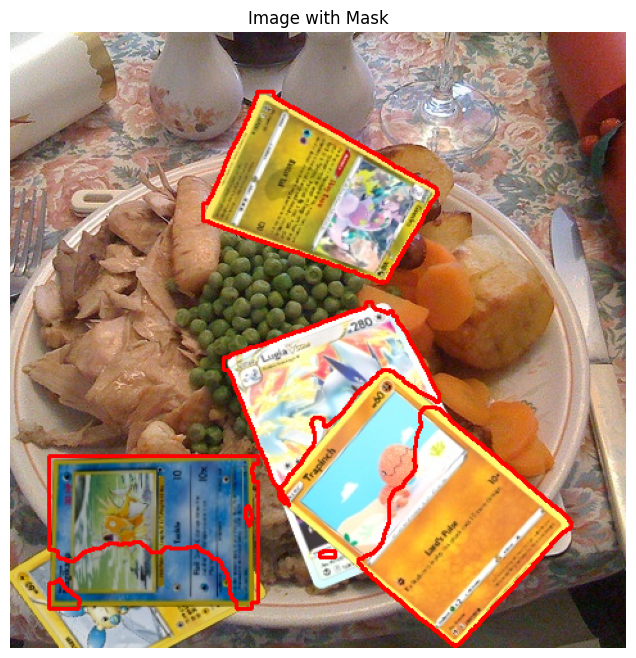

In [33]:
import matplotlib.pyplot as plt

# Load the original image
image_path = "datasets/yolo_dataset_seg/images/test/test_img_0.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Check if masks are present
if results[0].masks is not None:
    # Get masks from results
    masks = results[0].masks.data.cpu().numpy()

    # Overlay masks on the image
    for mask in masks:
        mask = (mask * 255).astype("uint8")
        color = (255, 0, 0)  # Red color for mask
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(image, contours, -1, color, 2)

# Plot the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.title("Image with Mask")
plt.show()

In [30]:
# Import essential libraries 
import requests 
import cv2 
import numpy as np 

# Replace the below URL with your own. Make sure to add "/shot.jpg" at last. 
url = "http://192.168.188.30:8080/shot.jpg"

# While loop to continuously fetch data from the URL
while True:
    img_resp = requests.get(url)
    img_arr = np.array(bytearray(img_resp.content), dtype=np.uint8)
    frame = cv2.imdecode(img_arr, -1)
    cropped_frame = center_crop(frame, target_size=(480, 480))
    # cropped_frame = frame

    # Run the model to get predictions
    results = model.predict(cropped_frame, imgsz=480, conf=0.23)

    for result in results:
        if result.masks is not None:  # Check if masks are available
            for mask, box, conf, cls in zip(result.masks.data, result.boxes.xyxy, result.boxes.conf, result.boxes.cls):
                # Resize the mask to match the frame size
                mask = mask[0].cpu().numpy()  # Convert the mask to a numpy array
                mask_resized = cv2.resize(mask, (cropped_frame.shape[1], cropped_frame.shape[0]))
                mask_binary = (mask_resized > 0.5).astype(np.uint8)  # Convert to binary mask
                
                # Create a colored overlay for the mask
                colored_mask = np.zeros_like(cropped_frame, dtype=np.uint8)
                colored_mask[mask_binary > 0] = (0, 255, 0)  # Green color for mask

                # Overlay the mask on the frame
                cropped_frame = cv2.addWeighted(cropped_frame, 1, colored_mask, 0.5, 0)

                # Get bounding box coordinates
                x1, y1, x2, y2 = map(int, box)
                label = model.names[int(cls)]
                conf = float(conf)

                # Draw the bounding box
                cv2.rectangle(cropped_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Add label and confidence score
                cv2.putText(cropped_frame, f"{label} {conf:.2f}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.imshow("Android_cam", cropped_frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()



0: 480x480 (no detections), 101.0ms
Speed: 3.0ms preprocess, 101.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 480)

0: 480x480 (no detections), 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 480)

0: 480x480 (no detections), 27.0ms
Speed: 1.0ms preprocess, 27.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 480)

0: 480x480 (no detections), 14.0ms
Speed: 1.0ms preprocess, 14.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 480)

0: 480x480 (no detections), 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 480)

0: 480x480 (no detections), 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 480)

0: 480x480 (no detections), 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 480)

0: 480x480 (no detections), 13.0ms
Speed: 1.0ms preprocess, 13.0ms

In [ ]:
# Import essential libraries 
import requests 
import cv2 
import numpy as np 

# Replace the below URL with your own. Make sure to add "/shot.jpg" at last. 
url = "http://192.168.188.30:8080/shot.jpg"

# While loop to continuously fetching data from the Url 
while True:
    # Fetch the frame from the phone camera
    img_resp = requests.get(url)
    img_arr = np.array(bytearray(img_resp.content), dtype=np.uint8)
    frame = cv2.imdecode(img_arr, cv2.IMREAD_COLOR)
    # frame = center_crop(frame, target_size=(480, 480))
    # Convert BGR frame to RGB for YOLO
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Perform inference
    results = model.predict(source=rgb_frame, imgsz=480, conf=0.25)

    # Check if masks are present
    if results[0].masks is not None:
        # Get masks from results
        masks = results[0].masks.data.cpu().numpy()
        height, width = frame.shape[:2]

        # Resize masks to match frame dimensions
        resized_masks = [cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST) for mask in masks]

        # Overlay masks on the frame
        for mask in resized_masks:
            mask = (mask * 255).astype("uint8")
            color_mask = np.zeros_like(frame)  # Create an empty mask frame
            color_mask[:, :, 1] = mask  # Apply the mask to the green channel for visualization

            # Blend the color mask with the original frame
            frame = cv2.addWeighted(frame, 0.7, color_mask, 0.3, 0)

    # Display the frame
    cv2.imshow("Android Cam with YOLO Masks", frame)

    # Press 'q' key to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Clean up
cv2.destroyAllWindows()


0: 480x480 (no detections), 87.0ms
Speed: 3.0ms preprocess, 87.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 480)

0: 480x480 (no detections), 56.0ms
Speed: 2.0ms preprocess, 56.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 480)

0: 480x480 (no detections), 49.0ms
Speed: 1.0ms preprocess, 49.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 480)

0: 480x480 (no detections), 52.0ms
Speed: 1.0ms preprocess, 52.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 480)

0: 480x480 (no detections), 50.0ms
Speed: 2.0ms preprocess, 50.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 480)

0: 480x480 (no detections), 24.0ms
Speed: 2.0ms preprocess, 24.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 480)

0: 480x480 (no detections), 25.0ms
Speed: 1.0ms preprocess, 25.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 480)

0: 480x480 (no detections), 24.0ms
Speed: 1.0ms preprocess, 24.0ms i